# **Описание проекта**
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики **RMSE** на тестовой выборке должно быть не больше **48**.

## **Инструкция по выполнению проекта**

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

**Описание данных**

Данные лежат в файле /datasets/taxi.csv. Скачать датасет.
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [30]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose



# **1. Загрузите данные и выполните их ресемплирование по одному часу.**

In [31]:
url = 'https://drive.google.com/file/d/1kC-LrZD4a5gzgHMd3QX45e06_ExUGQYt/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path, parse_dates=[0], index_col=[0])
data = df.copy()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [33]:
df.sort_index(inplace=True)
df.index.is_monotonic_increasing


True

In [34]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

Индекс датафрейма представлен типом `DatetimeIndex` при этом он монотонно возрастающий

Выполним ресемплирование по 1 часу и построим графики.

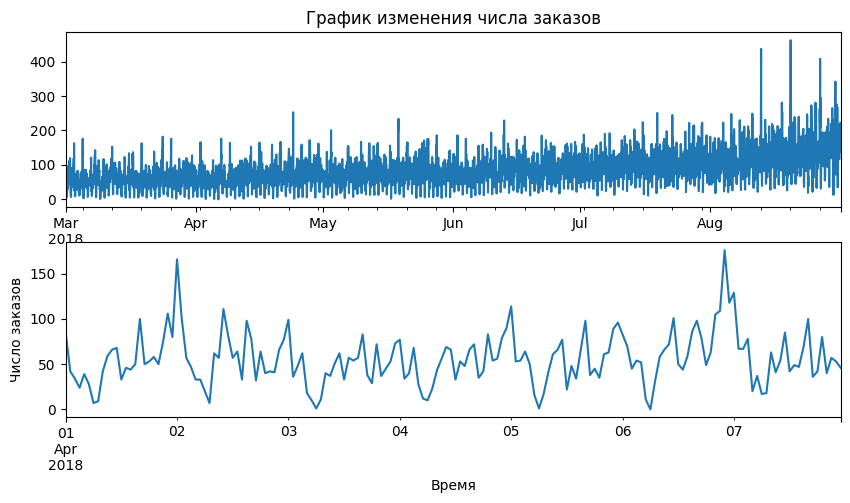

In [35]:
df = df.resample('1h').sum()
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
df.plot(ax=plt.gca(), legend=False)
plt.title('График изменения числа заказов')
plt.subplot(2,1,2)
df['2018-04-01':'2018-04-7'].plot(ax=plt.gca(), legend=False)
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.show()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB


После ресемплирования количество строк исходного датафрейма уменьшилось с 26496 до 4416 в 6 раз, так как в исходном датасете временной интервал составлял 10 мин, а после ресемплирования 1 час. Ресемплированный датафрейм после этого стал более "гладким".

# **2. Проанализируйте данные.**

In [37]:
df.isna().sum()

,0
num_orders,0


В датасете отсутсвуют пропущенные значения.

Разложим наш временной ряд на трендовую, сезонную и остаточную составляющие.

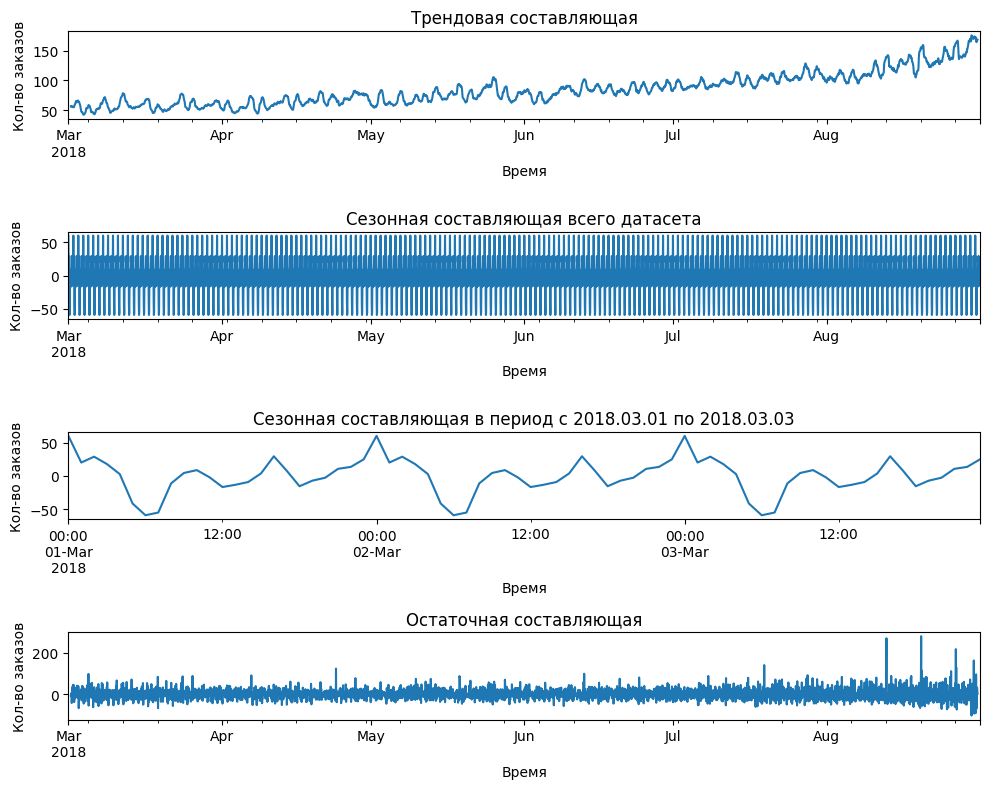

In [38]:
decomposed = seasonal_decompose(df['num_orders'])

def plot_graphs(title):
  plt.title(title)
  plt.xlabel('Время')
  plt.ylabel('Кол-во заказов')


plt.figure(figsize=(10, 8))
trend=None
seasonal=None
resid=None
for i, j, k in zip(['Трендовая составляющая',
                    'Сезонная составляющая всего датасета',
                    'Сезонная составляющая в период с 2018.03.01 по 2018.03.03',
                    'Остаточная составляющая'],
                     [decomposed.trend, decomposed.seasonal,
                      decomposed.seasonal['2018-03-01':'2018-03-03'],
                      decomposed.resid],
                     range(1,5)):

  plt.subplot(4,1,k )
  j.plot(ax=plt.gca())
  plot_graphs(i)
  plt.tight_layout()


 - временной ряд имеет возрастающий тренд, а так же суточную сезонность
 - данные представлены без пропусков 2018 годом периодом с марта по август

# **3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.**

## **3.1 Создание признаков**

Извлечем из индекса номер месяца, число месяца, номер дня недели и создадим признаки `month`, `day`, `dayofweek`.
Так как сезонная составляющая имеет суточный период повторения довавим еще 24 признака , каждый из которых будет смещен на один час относительно другого по количеству заказов.

In [39]:
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

for i in range(1,25):
  df.loc[:, 'lag_' + str(i)] = df['num_orders'].shift(i)
df = df.dropna()

Разделим выборки на обучающую, валидационную и тестовую в отношении 80:10:10.

In [40]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

features_train, features_valid, target_train, target_valid = train_test_split(
                                features, target, shuffle=False, test_size=0.2)

features_valid, features_test, target_valid, target_test = train_test_split(
                                features_valid, target_valid,
                                shuffle=False, test_size=0.5)
print(f'Размер обучающей выборки  - {features_train.shape}')
print(f'Размер валидационной выборки  - {features_valid.shape}')
print(f'Размер тестовой выборки  - {features_test.shape}')
print(f'Тестовая выборка составляет {(features_test.shape[0]/features.shape[0]):.0%} от исходного датасета')

Размер обучающей выборки  - (3513, 27)
Размер валидационной выборки  - (439, 27)
Размер тестовой выборки  - (440, 27)
Тестовая выборка составляет 10% от исходного датасета


Отмасштабируем все признаки с помощью `StandardScaler`

In [41]:
scaler = StandardScaler()
features_train = pd.DataFrame(scaler.fit_transform(features_train),
                              columns=features_train.columns,
                              index = features_train.index)

features_valid = pd.DataFrame(scaler.transform(features_valid),
                              columns=features_valid.columns,
                              index = features_valid.index)

features_test = pd.DataFrame(scaler.transform(features_test),
                              columns=features_test.columns,
                              index = features_test.index)

In [42]:
features_train.head()

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,-1.398079,-1.5644,0.498936,-0.459365,1.079107,-0.236513,-0.376290,-0.823676,-0.039200,-0.851677,...,-0.147064,-1.129545,-1.662326,-1.745380,-1.912275,-0.873143,-0.227385,-0.086860,0.306234,1.401021
2018-03-02 01:00:00,-1.398079,-1.5644,0.498936,0.436105,-0.459943,1.079084,-0.236335,-0.375702,-0.823542,-0.038040,...,-0.287507,-0.146378,-1.128603,-1.661125,-1.743845,-1.911752,-0.873008,-0.227218,-0.086783,0.306211
2018-03-02 02:00:00,-1.398079,-1.5644,0.498936,1.275609,0.435505,-0.460444,1.079246,-0.235711,-0.375346,-0.823621,...,0.611331,-0.286830,-0.145427,-1.127512,-1.659630,-1.743329,-1.911619,-0.872867,-0.227146,-0.086797
2018-03-02 03:00:00,-1.398079,-1.5644,0.498936,0.016354,1.274986,0.435281,-0.460263,1.080212,-0.235285,-0.374717,...,-1.242523,0.612066,-0.285881,-0.144542,-1.126269,-1.659118,-1.743196,-1.911518,-0.872818,-0.227157
2018-03-02 04:00:00,-1.398079,-1.5644,0.498936,-0.291464,0.015764,1.275024,0.435451,-0.459698,1.081289,-0.234435,...,-1.186346,-1.241907,0.613022,-0.284966,-0.143762,-1.125778,-1.658984,-1.743088,-1.911506,-0.872815


## **3.2 Линейная регрессия**

In [43]:
model = LinearRegression()
model.fit(features_train, target_train)

preds_valid = model.predict(features_valid)
rmse_valid_lr = root_mean_squared_error(target_valid, preds_valid)

print(f'RMSE на валидационной выборке равно {rmse_valid_lr:.2f}')



RMSE на валидационной выборке равно 34.15


In [44]:
def plot_result(target_valid, preds, legend):
  target_valid.plot(figsize=(15,5))
  pd.Series(preds, index=target_valid.index).plot(ax=plt.gca())
  plt.legend(legend)
  plt.show()

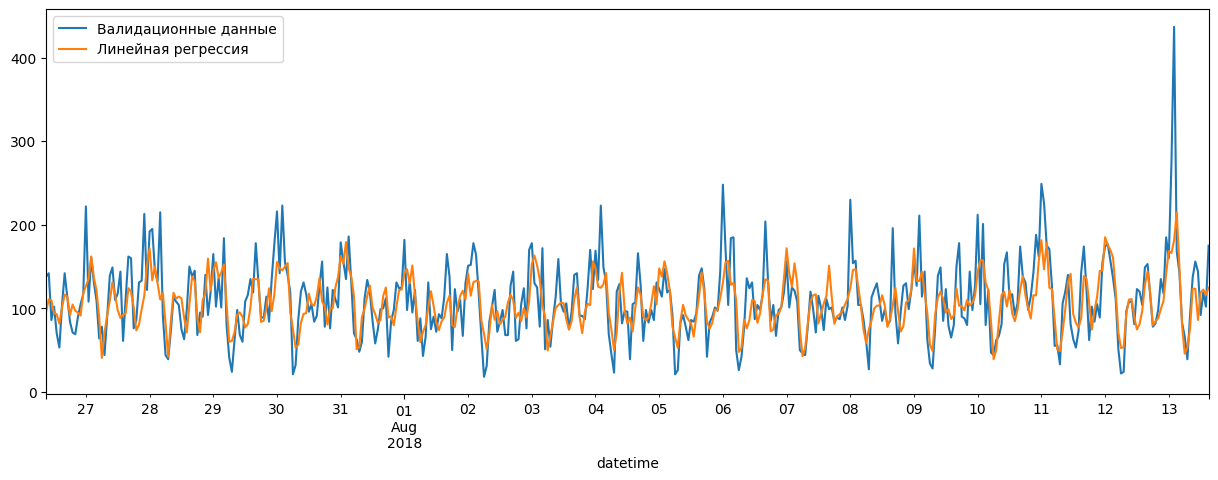

In [45]:
plot_result(target_valid, preds_valid, ['Валидационные данные', 'Линейная регрессия'])

## **3.2 Решающее дерево**

In [46]:
parameters = {
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split' : [32, 64, 128, 256]
}

In [47]:
tscv = TimeSeriesSplit(n_splits=3)
model_dtr = DecisionTreeRegressor(random_state=12345)
gs_dtr = GridSearchCV(model_dtr, parameters, n_jobs = -1, cv = tscv)
gs_dtr.fit(features_train, target_train)
gs_dtr.best_params_

{'max_depth': 7, 'min_samples_split': 128}

In [48]:
model_dtr = DecisionTreeRegressor(random_state=12345, **gs_dtr.best_params_)
model_dtr.fit(features_train, target_train)

preds_valid = model_dtr.predict(features_valid)
rmse_dtr = root_mean_squared_error(target_valid, preds_valid)

print(f'RMSE на валидационной выборке равно {rmse_dtr:.2f}')

RMSE на валидационной выборке равно 39.24


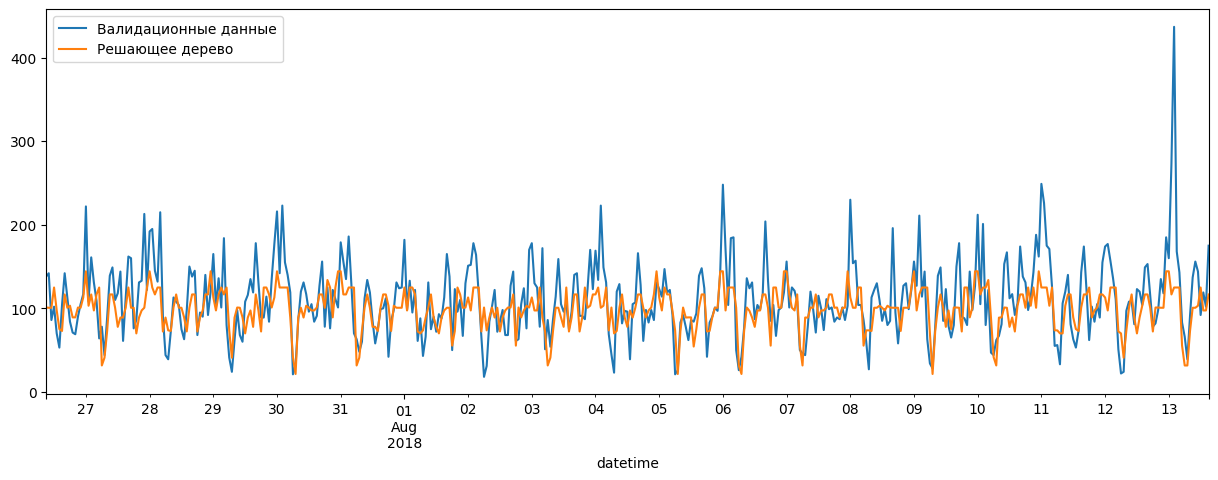

In [49]:
plot_result(target_valid, preds_valid, ['Валидационные данные', 'Решающее дерево'])

## **3.3 Случайный лес**

In [50]:
parameters = {
    'n_estimators' : [10, 50, 100],
    'max_depth' : [6, 7, 8],
    'max_features' : [12, 16, 24]
}


In [51]:
tscv = TimeSeriesSplit(n_splits=3)
model_rfr = RandomForestRegressor(random_state=12345)
gs_rfr = GridSearchCV(model_rfr, parameters, n_jobs = -1, cv = tscv)
gs_rfr.fit(features_train, target_train)
gs_rfr.best_params_

{'max_depth': 8, 'max_features': 16, 'n_estimators': 50}

In [52]:
model_rfr = RandomForestRegressor(**gs_rfr.best_params_)
model_rfr.fit(features_train, target_train)
preds = model_rfr.predict(features_valid)
rmse_rfr = root_mean_squared_error(target_valid, preds)
print(f'RMSE на валидационной выборке равно {rmse_rfr:.2f}')

RMSE на валидационной выборке равно 35.29


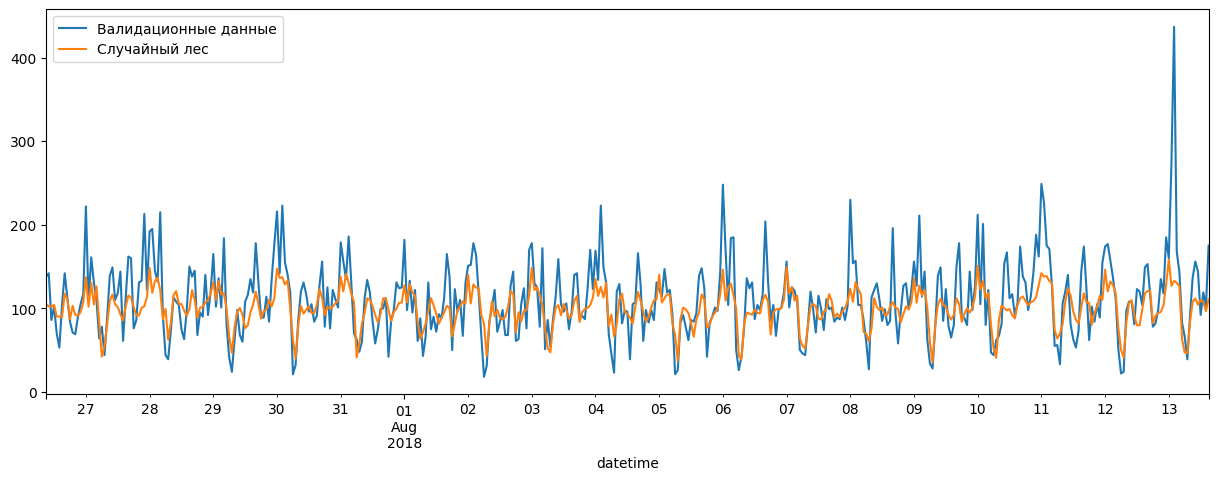

In [53]:
plot_result(target_valid, preds, ['Валидационные данные', 'Случайный лес'])

# **4. Проверьте данные на тестовой выборке и сделайте выводы.**

In [54]:
result = pd.DataFrame({'RMSE':[rmse_valid_lr, rmse_dtr, rmse_rfr]}, index=[
         'Линейная регрессия', 'Решающее дерево', 'Случайный лес']).sort_values(by='RMSE')
result

,RMSE
Линейная регрессия,34.151998
Случайный лес,35.289214
Решающее дерево,39.235431


Лучшей моделью себя показала модель линейной регрессии. Проверим ее работу на тестовых данных.

In [55]:
model = LinearRegression()
model.fit(features_train, target_train)

preds_test = model.predict(features_test)
rmse_test = root_mean_squared_error(target_test, preds_test)

print(f'RMSE на валидационной выборке равно {rmse_test:.2f}')

RMSE на валидационной выборке равно 46.17


Модель даже смогла достичь планки ниже  поставленной метрики RMSE. По заданию RMSE на тестовых данных должно быть не более **48**, модель показала **46.17**

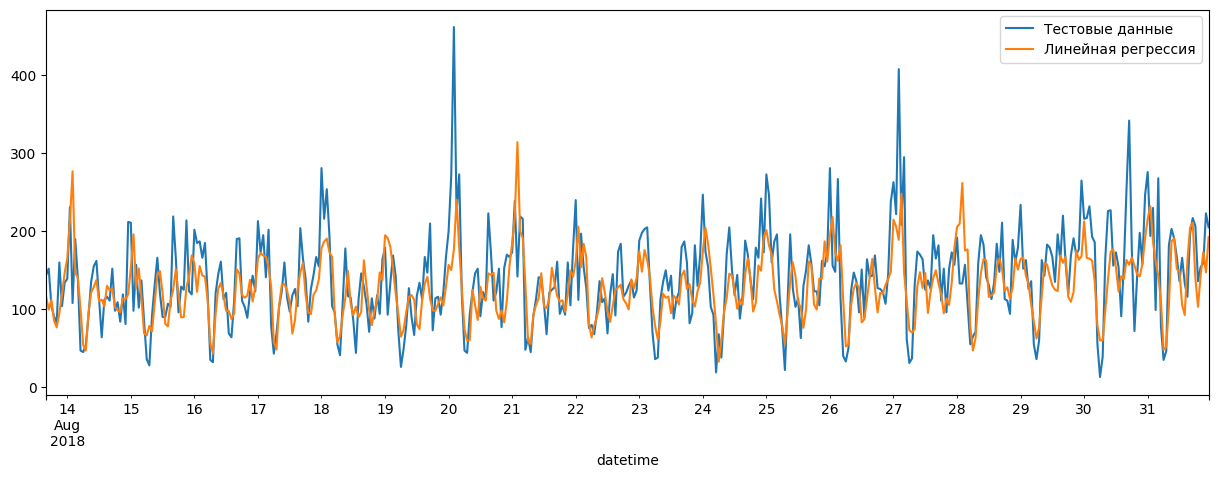

In [56]:
plot_result(target_test, preds_test, ['Тестовые данные', 'Линейная регрессия'])